## Summary: Edelweiss C and its Error

This notebook is a copy of edelweiss_C_systematicErrors_allParameters.ipynb, but using more accurate calculations for the NR and ER bands.

## Band Widths
Edelweiss parametrizes their band widths for all detectors (see eq'ns 9, 10, and 11 from the above paper).  

$$\sigma_{Q\gamma}(E_R) = \frac{1 + V/\epsilon}{E_R}\sqrt{\sigma_I^2 + \sigma_H^2}$$

$$\sigma_{Qn}(E_R) = \sqrt{C^2 + \frac{1}{E^2_R} \left( \left(1+\frac{V}{\epsilon}\langle Q_n\rangle\right)^2\sigma_I^2 + \left( 1+\frac{V}{\epsilon}\right)^2\langle Q_n\rangle^2\sigma_H^2\right)} $$

where $C$ is a fitted constant; $\epsilon$ is the average energy needed to create a single electron-hole pair in germanium (3 eV); and $\langle Q_n \rangle$, $\sigma_I^2$, and $\sigma_H^2$ are all functions of the true recoil energy $E_R$. The yield $\langle Q_n \rangle = 0.16 E_R^{0.18}$.  The terms $\sigma_I^2$ and $\sigma_H^2$ should be read as "the heat/ionization resolution for an energy deposit of $E_R$."  For the electron recoil band and $\sigma_{Q\gamma}$, the arguments for$\sigma_I^2$ $\sigma_H^2$ are $E_R$ since for electron recoils, $E_I = E_R$ and $E_H = E_R$.  For nuclear recoils the heat and ionization energy are not identical to the energy $E_R$ and are defined in the section below.

In [1]:
import numpy as np
from scipy.special import erf
from scipy.stats import multivariate_normal
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
from scipy import optimize
import lmfit as lmf
import emcee

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

GGA3/NR/4.0/5.556E-02/0.0380/000/0.1493/0.1782/0.9975/
GGA3/NR/4.0/5.556E-02/0.0381/000/0.1537/0.1703/0.9948/


In [2]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

In [3]:
from edelweiss_fit import *

# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}

## Fit with an MCMC method

### Understanding the ER and NR likelihood functions
The model used for the ER yield width is `series_NRQ_var` which is the moment expansion of the variance out to $E^{-6}$.  The parameters passed to this function set the yield to one. 

The model used for for the NR yield width is `series_NRQ_var_corr1` with an additional linear-in-energy width added in quadrature.  The function `series_NRQ_var_corr1` uses the function modeling the ER band but with a different yield plus an energy-dependent correction that makes the value at the "nominal" parameters equal to the exact calculated value.

In [4]:
def getCov_fromCoeff(a, b, c):
    Var_x = 4*np.pi/(np.sqrt(c)*np.power(4*a - b**2/c ,3/2))
    Var_y = 4*np.pi*a/np.power(4*a*c - b**2 ,3/2)
    Var_xy = 2*np.pi*b/np.power(4*a*c - b**2 ,3/2)
    
    return [[Var_x, Var_xy], [Var_xy, Var_y]]

def getCoeff(sig_x, sig_y, theta):
    a = np.power(np.cos(theta),2)/(2*sig_x*sig_x) + np.power(np.sin(theta),2)/(2*sig_y*sig_y)
    b = 2*np.cos(theta)*np.sin(theta)/(2*sig_y*sig_y) - 2*np.cos(theta)*np.sin(theta)/(2*sig_x*sig_x)
    c = np.power(np.cos(theta),2)/(2*sig_y*sig_y) + np.power(np.sin(theta),2)/(2*sig_x*sig_x)
    
    return a, b, c
    
def getCov(sig_x, sig_y, theta):
    a, b, c = getCoeff(sig_x, sig_y, theta)
    return getCov_fromCoeff(a, b, c)

def evalBivariatePDF(energies_keV, mu_x, mu_y, sig_x, sig_y, A, B):
    pdf_arr = []
    
    for Erecoil_keV in energies_keV:
        slope = -1/(0.16*np.log(Erecoil_keV))
        theta = np.arctan(slope) + np.pi/2
        cov_matrix = getCov(sig_x, sig_y, theta)
        rv = multivariate_normal([mu_x, mu_y], cov_matrix)
        pdf_arr.append(rv.pdf([[A, B]]))
        
    return pdf_arr

In [5]:
def log_likelihood(theta, ER_data, NR_data):
    aH, C, m, scale, A, B = theta
    V = np.abs(scale)*4.0
    
    # extract the data
    x_ER, y_ER, yerr_ER = ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err']
    x_NR, y_NR, yerr_NR = NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']
    
    # expected parameter values and widths
    # uncertainty on aH is the uncertainty on the parameter aH when fitting only the ER band
    # scale width estimated by assuming a 10 mV error on V and 0.5 eV error on epsilon
    # information for A and B from Astroparticle Physics 14 (2001) 329±337
    # Anthony's function use the FWHM version of aH
    exp_aH = 0.016*2*np.sqrt(2*np.log(2))
    exp_aH_sig = exp_aH*0.046
    exp_scale = 1
    exp_scale_sig = 0.17
    exp_A = 0.16
    exp_A_sig = 0.07
    exp_B = 0.18
    exp_B_sig = 0.1
    exp_Y = 0.3
    exp_Y_sig = 0.1
    
    ## get the ER prediction for the input parameters
    model_ER = [np.sqrt(series_NRQ_var(x,V=V,aH=aH,A=1.0,B=0.0,alpha=0.0000001)) for x in x_ER]
    sigma2_ER = yerr_ER**2
    
    ## get the NR prediction for the input parameters
    # series_NRQ_var_corr1(Er=10.0,F=0.0,V=4.0,aH=0.0381,alpha=(1/18.0),A=0.16,B=0.18,label='GGA3',corr1file='data/sigdiff_test.h5')
    # series_NRQ_var_corr1 returns the *variance*
    model_NR_0 = [sigmomEdw(x, band='NR',label='GGA3',F=0.000001, V=V, aH=aH, alpha=1/18.0, A=A, B=B) for x in x_NR] 
    model_NR = np.sqrt(np.power(C + m*x_NR, 2) + np.power(model_NR_0, 2))
    sigma2_NR = yerr_NR**2
    
    return -0.5*(np.sum((y_NR-model_NR)**2/sigma2_NR + np.log(2*np.pi*sigma2_NR)) \
                 + np.sum((y_ER-model_ER)**2/sigma2_ER + np.log(2*np.pi*sigma2_ER)) \
                 + (aH - exp_aH)**2/exp_aH_sig**2 \
                 + (scale - exp_scale)**2/exp_scale_sig**2) \
                 + np.sum(np.log(evalBivariatePDF([np.max(x_NR)], exp_A, exp_B, exp_A_sig, exp_B_sig, A, B)))

## Find the minimum likelihood

When all six parameters are allowed to vary, the solution finds a small value for A and a larger value for B:

aH, C, m, scale, A, B = array([1.59557510e-02, 4.01120006e-02, 4.11442471e-05, 1.03493435e+00, 1.16847345e-01, 1.52032678e-01])

### Global minimization results
Brute: sadly this does not complete in a reasonable time (less than a day)

Basinhopping: does not successfully converge on a solution

SHGO: overflows occur in the yeild function but it still reports converging successfully with a function value of -53.623 and solution of xl: array([[1.59555935e-02, 4.01182258e-02, 4.10754863e-05, 1.03491851e+00,
        1.16818488e-01, 1.51974313e-01]]).


In [6]:
# if fit_test is false then the fit will be run
fit_test = False

# if mcmc_test is false then the MCMC sampler will be run
mcmc_test = False

# if do_sample_NR_test is false then fit parameters will be sampled from MCMC
do_sample_NR_test = False

aH:  0.03861904873850757
log-likelihood:  55.519016756523435
[0.030247971807886454, 0.050775118624689336, 0.01782771424730619, 0.024353005418275828, 0.037655766669535955] 2    0.049321
3    0.062885
4    0.047452
5    0.047073
6    0.053506
Name: E_recoil, dtype: float64


(10.0, 200.0)

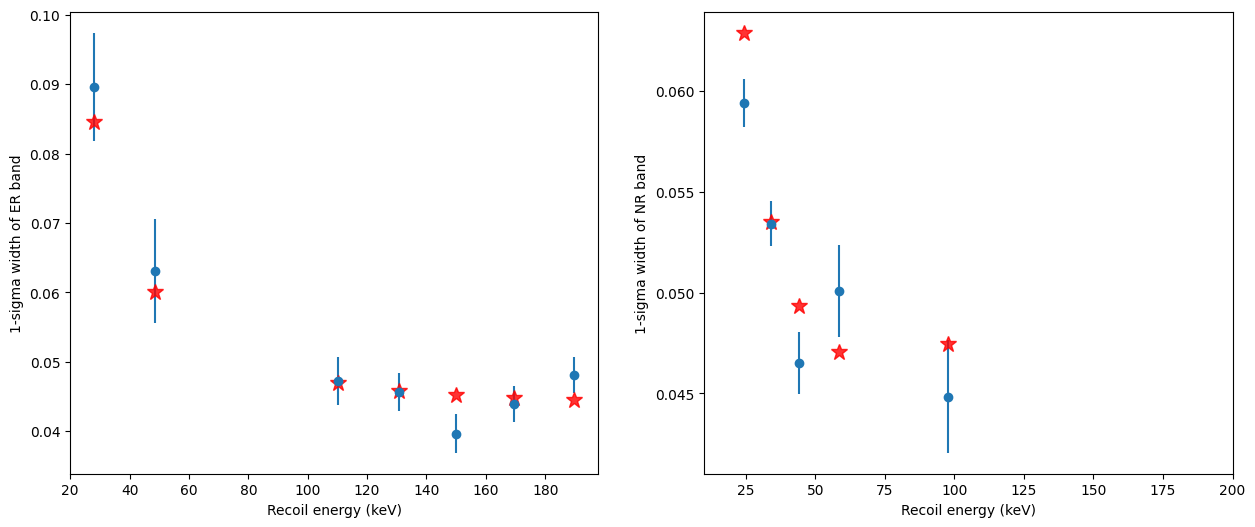

In [7]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
# the ER-band fit
ax1 = axs[0]
ax2 = axs[1]

# plot the initial parameters
# GGA3 parameters from Edelweiss tables
# all the parameters affect the points as expected
#aH, C, m, scale, A, B = 0.0164*2*np.sqrt(2*np.log(2)), 0.0348, 9.39E-5, 1.0, 0.16, 0.18
aH, C, m, scale, A, B = 0.0164*2*np.sqrt(2*np.log(2)), 0.0348, 9.39E-5, 1.0, 0.16, 0.18
V = scale*4.0
print ("aH: ", aH)
print ("log-likelihood: ", log_likelihood((aH, C, m, scale, A, B), ER_data, NR_data))

## get the ER prediction for the input parameters
model_ER = [np.sqrt(series_NRQ_var(x,V=V,aH=aH,A=1.0,B=0.0,alpha=0.0000001)) for x in ER_data['Erecoil']]

## get the NR prediction for the input parameters
# series_NRQ_var_corr1(Er=10.0,F=0.0,V=4.0,aH=0.0381,alpha=(1/18.0),A=0.16,B=0.18,label='GGA3',corr1file='data/sigdiff_test.h5')
# series_NRQ_var_corr1 returns the *variance*
model_NR_0 = [sigmomEdw(x, band='NR',label='GGA3',F=0.000001, V=V, aH=aH, alpha=1/18.0, A=A, B=B) for x in NR_data['Erecoil']] 
model_NR = np.sqrt(np.power(C + m*NR_data['Erecoil'], 2) + np.power(model_NR_0,2))
print (model_NR_0, model_NR)

ax1.plot(ER_data['Erecoil'], model_ER, 'r*', alpha=0.8, markersize=12)
ax2.plot(NR_data['Erecoil'], model_NR, 'r*', alpha=0.8, markersize=12)

# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
    
plt.xlim(10, 200)
#ax2.set_ylim(0.04, 0.1)

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,6))
(ax1, ax2), (ax3, ax4) = axs

aH, C, m, scale, A, B = 0.0164*2*np.sqrt(2*np.log(2)), 0.0348, 9.39E-5, 1.0, 0.16, 0.18
aH_min = aH*(1-0.2)
aH_max = aH*(1+0.2)
aH_arr = np.linspace(aH_min, aH_max, 10)
logll_arr = [-log_likelihood((x, C, m, scale, A, B), ER_data, NR_data) for x in aH_arr]
ax1.plot(aH_arr, logll_arr, '*')

C_min, C_max = [0.0, 0.048] 
C_arr = np.linspace(C_min, C_max, 10)
logll_arr_C = [-log_likelihood((aH, x, m, scale, A, B), ER_data, NR_data) for x in C_arr]
ax2.plot(C_arr, logll_arr_C, '*')

scale_min, scale_max = [0, 1.2]
scale_arr = np.linspace(scale_min, scale_max, 10)
logll_arr_scale = [-log_likelihood((aH, C, m, x, A, B), ER_data, NR_data) for x in scale_arr]
ax3.plot(scale_arr, logll_arr_scale, '*')

A_min, A_max = [0, 0.3]
A_arr = np.linspace(A_min, A_max, 10)
logll_arr_A = [-log_likelihood((aH, C, m, scale, x, B), ER_data, NR_data) for x in A_arr]
ax4.plot(A_arr, logll_arr_A, '*')

../python/prob_dist.py:402: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(q2-mean**2))


In [ ]:
# Final result: [3.80087771e-02, 3.22428020e-02, 1.23069856e-04, 9.99751973e-01, 1.49279368e-01, 1.78235616e-01]

# the number of function evaluations is about 560
if not fit_test:
    # start at about the minimum
    aH, C, m, scale, A, B = 0.0164*2*np.sqrt(2*np.log(2)), 0.0348, 9.39E-5, 1.0, 0.16, 0.18
    aH_min = aH*(1-0.2)
    aH_max = aH*(1+0.2)    

    from scipy import optimize
    #np.random.seed(42)

    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([aH, C, m, scale, A, B]) #+ 0.001*np.random.randn(2)
    #soln = optimize.minimize(nll, initial, method='Nelder-Mead', args=(ER_data, NR_data), options={'adaptive':True})
    #aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit = soln.x
    
    #soln = optimize.brute(nll, ([0.0135, 0.018], [0.024, 0.048], [-0.0001, 0.0002], [0.9, 1.2], [0.06, 0.24], [0.06, 0.24]), args=(ER_data, NR_data))
    #soln = optimize.basinhopping(nll, initial, minimizer_kwargs={'args': (ER_data, NR_data)})
    soln = optimize.shgo(nll, ([aH_min, aH_max], [0.024, 0.048], [-0.0001, 0.0002], [0.9, 1.2], [0.06, 0.24], [0.06, 0.24]), args=(ER_data, NR_data))
    aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit = soln.x

    with open('fit_results_sigmom_corrAB.txt', 'w') as f:
        print (soln, file=f)
    print ("The number of function evaluations: ", soln.nfev)
    print ("The number of function evaluations in local minima: ", soln.nlfev)
else:
    aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit = np.array([3.80087771e-02, 3.22428020e-02, 1.23069856e-04, 9.99751973e-01,1.49279368e-01, 1.78235616e-01])

In [ ]:
print ("log-likelihood: ", log_likelihood((aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit), ER_data, NR_data))

fig, axs = plt.subplots(1,2,figsize=(15,6))
# the ER-band fit
ax1 = axs[0]
ax2 = axs[1]

# plot the best fit
# GGA3 parameters from Edelweiss tables
# all the parameters affect the points as expected
V_fit = abs(scale_fit)*4.0

## get the ER prediction for the input parameters
## note that you should not use A_fit and B_fit for the ER model!
model_ER = [np.sqrt(series_NRQ_var(x,V=V_fit,aH=aH_fit,A=1.0,B=0.0,alpha=0.0000001)) for x in ER_data['Erecoil']]

## get the NR prediction for the input parameters
# series_NRQ_var_corr1(Er=10.0,F=0.0,V=4.0,aH=0.0381,alpha=(1/18.0),A=0.16,B=0.18,label='GGA3',corr1file='data/sigdiff_test.h5')
# series_NRQ_var_corr1 returns the *variance*
#model_NR_0 = [series_NRQ_var_corr1(x, 0, V_fit, aH_fit, 1/18.0, A_fit, B_fit, 'GGA3') for x in NR_data['Erecoil']] 
#model_NR = np.sqrt(np.power(C_fit + m_fit*NR_data['Erecoil'], 2) + model_NR_0)

model_NR_0 = [sigmomEdw(x, band='NR',label='GGA3',F=0.000001, V=V_fit, aH=aH_fit, alpha=1/18.0, A=A_fit, B=B_fit) for x in NR_data['Erecoil']] 
model_NR = np.sqrt(np.power(C_fit + m_fit*NR_data['Erecoil'], 2) + np.power(model_NR_0,2))

ax1.plot(ER_data['Erecoil'], model_ER, 'r*', alpha=0.8, markersize=12)
ax2.plot(NR_data['Erecoil'], model_NR, 'r*', alpha=0.8, markersize=12)

# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
    
plt.xlim(10, 200)
ax2.set_ylim(0.035, 0.1)
ax1.set_ylim(0.035, 0.1)